In [1]:
from sklearn.datasets import fetch_mldata
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.io.wavfile
import itertools

In [2]:
minist = fetch_mldata('MNIST original')

In [3]:
X,y = minist["data"], minist["target"]
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [4]:
#pick up image 5 and 6 from the dataset
#get the train set of image
five_train_image = list(range(40))
six_train_image = list(range(40))

count5 = -1
for i in range(len(y_train)):
    if y_train[i] == 5:
        count5 = count5 + 1
        five_train_image[count5] = np.array(X_train[i,:])
    if count5 == 39:
        break

count6 = -1
for i in range(len(y_train)):
    if y_train[i] == 6:
        count6 = count6 + 1
        six_train_image[count6] = np.array(X_train[i,:])
    if count6 == 39:
        break

In [5]:
#get the test set with five '5' image and five '6' image
five_test_image = list(range(5))
six_test_image = list(range(5))

count5 = -1
for i in range(len(y_test)):
    if y_test[i] == 5:
        count5 = count5 + 1
        five_test_image[count5] = np.array(X_test[i,:])
    if count5 == 4:
        break

count6 = -1
for i in range(len(y_test)):
    if y_test[i] == 6:
        count6 = count6 + 1
        six_test_image[count6] = np.array(X_test[i,:])
    if count6 == 4:
        break

In [6]:
#combine the test set of image
test_image = np.vstack((five_test_image,six_test_image))

In [7]:
five_train_voice = []
six_train_voice = []
test_voice = []

In [8]:
#get the test and train set of voice
for i in range(40):
    rate, five = scipy.io.wavfile.read("five_train/5_jackson_"+str(i)+".wav",mmap=False)
    rate, six = scipy.io.wavfile.read("six_train/6_jackson_"+str(i)+".wav",mmap=False)
    five_train_voice.append(np.asarray(five))
    six_train_voice.append(np.asarray(six))

for i in range(10):
    rate, t = scipy.io.wavfile.read("test/"+str(i)+".wav",mmap=False)
    test_voice.append(np.asarray(t))

In [9]:
max_len = np.max([np.max([len(a) for a in five_train_voice]), np.max([len(a) for a in six_train_voice]), np.max([len(a) for a in test_voice])]) 

In [10]:
#make the vectors of voice have same length
five_train_voice = np.asarray([np.pad(a,(0, max_len - len(a)),'constant', constant_values=0) for a in five_train_voice])
six_train_voice = np.asarray([np.pad(a,(0, max_len - len(a)),'constant', constant_values=0) for a in six_train_voice])
test_voice = np.asarray([np.pad(a,(0, max_len - len(a)),'constant', constant_values=0) for a in test_voice])

In [11]:
#let me first def a method to get the distance for knn
def avg_min_distance(dataset, k ):
    store_min = []
    for i in range(k):
        min1 = min(dataset)
        store_min.append(min1)
        dataset = np.delete(dataset, np.argmin(dataset))
    return np.mean(store_min)

In [12]:
#value the distance of voice using norm
five_voice_distances = list(range(10))
six_voice_distances = list(range(10))
for i in range(10):
    test_val = test_voice[i]/np.linalg.norm(test_voice[i])
    five_voice_distance = [np.linalg.norm(five/(np.linalg.norm(five)) - test_val) for five in five_train_voice]
    six_voice_distance = [np.linalg.norm(six/np.linalg.norm(six) - test_val) for six in six_train_voice]
    five_voice_distances[i] = np.asarray(five_voice_distance)
    six_voice_distances[i] = np.asarray(six_voice_distance)

In [13]:
#value the distance of image using norm
five_image_distances = list(range(10))
six_image_distances = list(range(10))
for i in range(10):
    test_val = test_image[i]/np.linalg.norm(test_image[i])
    five_image_distance = [np.linalg.norm(five/(np.linalg.norm(five)) - test_val) for five in five_train_image]
    six_image_distance = [np.linalg.norm(six/np.linalg.norm(six) - test_val) for six in six_train_image]
    five_image_distances[i] = np.asarray(five_image_distance)
    six_image_distances[i] = np.asarray(six_image_distance)

In [14]:
#mix the the distance of voice and image by treating them as a 2-by-1 vector and calculate its length
five_distances = list(range(10))
six_distances = list(range(10))
for i in range(10):
    five_distance = np.zeros(40)
    six_distance = np.zeros(40)
    for j in range(40):
        five_distance[j] = (five_image_distances[i][j]**2 + five_voice_distances[i][j]**2)**.5
        six_distance[j] = (six_image_distances[i][j]**2 + six_voice_distances[i][j]**2)**.5
    five_distances[i] = np.asarray(five_distance)
    six_distances[i] = np.asarray(six_distance)


In [28]:
#let's see the result of knn with 1
result = []
#cloest neighbor method with k 
for m in range(10):
    if avg_min_distance(five_distances[m],1) < avg_min_distance(six_distances[m],1):
        result.append(5)
    else:
        result.append(6)

In [29]:
result
#result looks not bad >_<
#real order: 5 5 5 5 5 6 6 6 6 6 

[5, 5, 5, 5, 5, 6, 6, 6, 6, 6]

In [17]:
#transfer the value of test set order, let '5' be '1' and '6' be '0'
test_class = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [85]:
#in order to get the ROC curve, let's define a confidence value to classify target as positive-
#-value: averge mini distance from target to the '6' set - averge mini distance from target to the '5' set
def score(k):  #k is the paramter in kmm
    test_score = np.zeros(10)
    for m in range(10):
        test_score[m] = avg_min_distance(six_distances[m], k ) - avg_min_distance(five_distances[m],k)
    return test_score
        

In [86]:
from sklearn.metrics import roc_curve

In [188]:
#function for ploting the ROC curve
def plot_roc_curve(fpr, tpr, label = None):
    co_ft = np.transpose(np.vstack((fpr, tpr)))
    co_ft = sorted(co_ft, key = lambda co_ft: co_ft[1])
    co_ft = sorted(co_ft, key = lambda co_ft: co_ft[0])
    fpr1,tpr1 = np.hsplit(np.asarray(co_ft),2)
    plt.plot(fpr1, tpr1, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

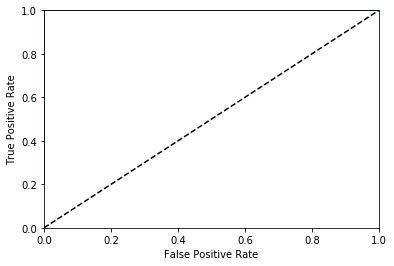

In [203]:
#the roc is on the top-left corner
fpr, tpr, thresholds = roc_curve(test_class, score(34))
plot_roc_curve(fpr, tpr)
plt.show()

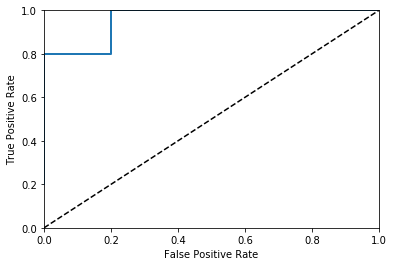

In [204]:
#the roc field turns to be smaller afer k = 35
fpr, tpr, thresholds = roc_curve(test_class, score(35))
plot_roc_curve(fpr, tpr)
plt.show()

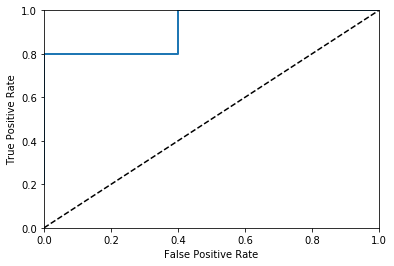

In [205]:
fpr, tpr, thresholds = roc_curve(test_class, score(39))
plot_roc_curve(fpr, tpr)
plt.show()

In [227]:
#for k before 34, we have auc = 1
from sklearn.metrics import roc_auc_score
auc = np.zeros(40)
for i in range(1,41):
    auc[i-1] = roc_auc_score(test_class,score(i))

In [228]:
#the result of auc is shown below.
auc

array([ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.96,  0.96,
        0.96,  0.92,  0.92,  0.88])

In [226]:
#learning from the result of auc, i think k value that is below 35 is a good choice for the dataset.

ValueError: min() arg is an empty sequence